##Financial Market Prediction

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##Data Gathering


In [ ]:
shareName = 'BHARATFORG.BO'
period = '25y'
ticker = yf.Ticker(shareName)
dataset = ticker.history(period=period)
dataset.reset_index(inplace=True)                               
dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date 
dataset['Date'] = pd.to_datetime(dataset['Date'])  
dataset.set_index('Date', inplace=True)               
dataset.head()                               

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1998-02-02,4.698195,4.698195,4.698195,4.698195,721,0.0,0.0
1998-02-03,4.625914,4.640371,4.553635,4.575319,77794,0.0,0.0
1998-02-04,4.625914,4.625914,4.481355,4.488583,159383,0.0,0.0
1998-02-05,4.358479,4.553635,4.358479,4.539179,9280,0.0,0.0
1998-02-06,4.409075,4.553635,4.401846,4.488583,11858,0.0,0.0


In [ ]:
colName = 'Close'
actualCol = 'Actual' + colName
predictedCol = 'Predicted' + colName
dataset.rename(columns={colName: actualCol}, inplace=True)
dataset = dataset.filter(items=[actualCol])
dataset.head()
# dataset.tail()

,ActualClose
Date,
1998-02-02,4.698195
1998-02-03,4.575319
1998-02-04,4.488583
1998-02-05,4.539179
1998-02-06,4.488583


#LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
trainPercent = 0.7
totalSize = dataset.shape[0]
trainIndex = int(trainPercent * totalSize)
trainingSet = dataset.iloc[:trainIndex]
testingSet = dataset.iloc[trainIndex:]

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
scaling = False
# scaling = True
if scaling:
  scaler.fit(trainingSet)
  scaledTrain = scaler.transform(trainingSet)
  scaledTest = scaler.transform(testingSet)
else:
  scaledTrain = trainingSet.values
  scaledTest = testingSet.values

In [ ]:
window = 15
n_features = 1
generator = TimeseriesGenerator(scaledTrain, scaledTrain, length=window, batch_size=1)

In [ ]:
X,y = generator[1]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[4.57531881 4.48858309 4.53917933 4.48858309 4.38016176 4.27897072
 4.33679628 4.28981304 4.30065775 4.2717433  4.24283266 4.22837496
 4.19223595 4.13802576 4.14886713]
Predict this y: 
 [[4.09465742]]


In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(window, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator, epochs=25)

Epoch 1/25
4374/4374 [==============================] - 46s 10ms/step - loss: 317.6275 - mean_absolute_error: 8.6392
Epoch 2/25
4374/4374 [==============================] - 30s 7ms/step - loss: 184.7102 - mean_absolute_error: 7.0740
Epoch 3/25
4374/4374 [==============================] - 30s 7ms/step - loss: 280.2839 - mean_absolute_error: 6.6772
Epoch 4/25
4374/4374 [==============================] - 32s 7ms/step - loss: 146.0284 - mean_absolute_error: 5.3560
Epoch 5/25
4374/4374 [==============================] - 30s 7ms/step - loss: 100.1689 - mean_absolute_error: 4.8649
Epoch 6/25
4374/4374 [==============================] - 30s 7ms/step - loss: 80.4328 - mean_absolute_error: 4.8299
Epoch 7/25
4374/4374 [==============================] - 30s 7ms/step - loss: 76.3993 - mean_absolute_error: 4.7304
Epoch 8/25
4374/4374 [==============================] - 30s 7ms/step - loss: 69.0874 - mean_absolute_error: 4.4864
Epoch 9/25
4374/4374 [==============================] - 30s 7ms/step - los

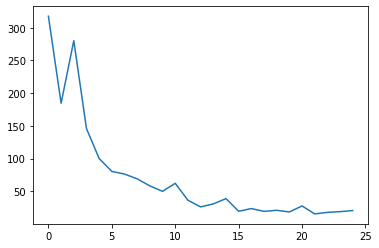

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaledTrain[-window:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, window, n_features))

In [ ]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 162ms/step


array([[550.79895]], dtype=float32)

In [ ]:
test_predictions = []

first_eval_batch = scaledTrain[-window:]
current_batch = first_eval_batch.reshape((1, window, n_features))

for i in range(len(scaledTest)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred[0]) 
  current_batch = np.append(current_batch[:,1:,:],[[scaledTest[i]]], axis=1)

1/1 [==============================] - 0s 20ms/step


In [ ]:
if scaling: 
  test_predictions = np.reshape(test_predictions, (-1, 1))
  true_predictions = scaler.inverse_transform(test_predictions)
else: true_predictions = test_predictions

In [ ]:
testingSet[predictedCol] = true_predictions

<ipython-input-44-b23ed3461d27>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testingSet[predictedCol] = true_predictions


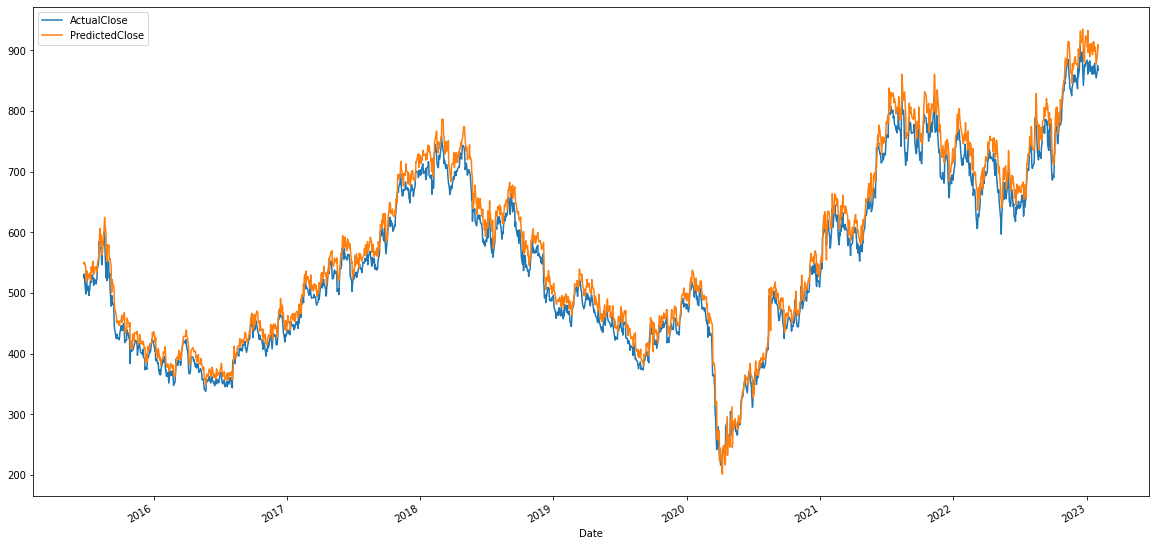

In [ ]:
testingSet.plot(figsize=(20, 10))

In [ ]:
testingSet

,ActualClose,PredictedClose
Date,,
2015-06-24,525.587463,550.798950
2015-06-25,531.168884,547.706970
2015-06-26,523.054810,549.738220
2015-06-29,501.995605,543.431458
2015-06-30,498.571777,524.484985
...,...,...
2023-01-27,854.599976,876.567627
2023-01-30,865.599976,891.557373
2023-01-31,875.200012,896.091003


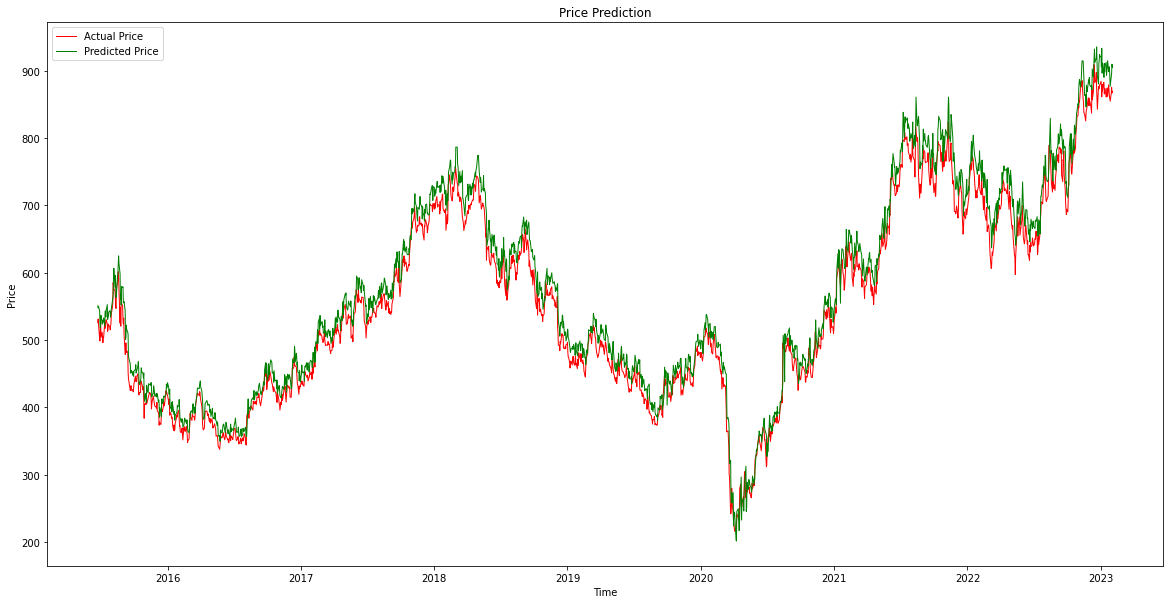

In [ ]:
plt.figure(figsize=(20,10))
testingSet.reset_index(inplace=True)
plt.plot(testingSet['Date'], testingSet[actualCol].values, color = 'red', linewidth = 1, label = 'Actual Price')
plt.plot(testingSet['Date'], testingSet[predictedCol].values, color = 'green', linewidth = 1, label = 'Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

###Error calculation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

In [ ]:
meanSquaredError = mean_squared_error(testingSet[actualCol].values, testingSet[predictedCol].values)
print("Mean Square Error :", meanSquaredError)

Mean Square Error : 641.1545020554516


In [ ]:
rootMeanSquare = sqrt(meanSquaredError)
print("Root Mean Square Error :", rootMeanSquare)

Root Mean Square Error : 25.321028850650038


In [ ]:
meanAbsoluteError = mean_absolute_error(testingSet[actualCol].values, testingSet[predictedCol].values)
print("Mean Absolute Error :", meanAbsoluteError)

Mean Absolute Error : 21.47317185437388


In [ ]:
r2Score = r2_score(testingSet[actualCol].values, testingSet[predictedCol].values)
print("R2 Score :", r2Score)

R2 Score : 0.9695608459228291
